In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("./data/labeled_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7996 entries, 0 to 7995
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   _id                       7996 non-null   object 
 1   TimeStamp                 7996 non-null   object 
 2   PART_FACT_PLAN_DATE       7996 non-null   object 
 3   PART_FACT_SERIAL          7996 non-null   int64  
 4   PART_NAME                 7996 non-null   object 
 5   EQUIP_CD                  7996 non-null   object 
 6   EQUIP_NAME                7996 non-null   object 
 7   PassOrFail                7996 non-null   object 
 8   Reason                    71 non-null     object 
 9   Injection_Time            7996 non-null   float64
 10  Filling_Time              7996 non-null   float64
 11  Plasticizing_Time         7996 non-null   float64
 12  Cycle_Time                7996 non-null   float64
 13  Clamp_Close_Time          7996 non-null   float64
 14  Cushion_

In [3]:
data = df.drop(["_id", "TimeStamp","PART_FACT_PLAN_DATE", "Reason", "PART_FACT_SERIAL",
               "EQUIP_NAME", "EQUIP_CD", "Switch_Over_Position",
               "Mold_Temperature_1","Mold_Temperature_2","Mold_Temperature_5","Mold_Temperature_6",
               "Mold_Temperature_7","Mold_Temperature_8","Mold_Temperature_9","Mold_Temperature_10",
               "Mold_Temperature_11","Mold_Temperature_12","Barrel_Temperature_7"],
             axis=1)

In [4]:
data["PassOrFail"] = data["PassOrFail"].replace("Y",1).replace("N",0)

C:\Users\Admin\AppData\Local\Temp\ipykernel_11896\3666244396.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["PassOrFail"] = data["PassOrFail"].replace("Y",1).replace("N",0)


In [5]:
data = data.drop(columns=["Filling_Time", "Plasticizing_Time", "Cycle_Time", "Plasticizing_Position", "Clamp_Open_Position",
                "Max_Injection_Speed", "Max_Switch_Over_Pressure", "Max_Back_Pressure", "Barrel_Temperature_2",
                "Barrel_Temperature_3", "Barrel_Temperature_5", "Barrel_Temperature_6"])

In [6]:
data = data.drop(columns=["Mold_Temperature_4"])

In [7]:
data = data.drop(columns=["Cushion_Position"])

In [8]:
cn7 = data[(data["PART_NAME"] == "CN7 W/S SIDE MLD'G RH") |(data["PART_NAME"] == "CN7 W/S SIDE MLD'G LH")]
rg3 = data[(data["PART_NAME"] == "RG3 MOLD'G W/SHLD, LH") |(data["PART_NAME"] == "RG3 MOLD'G W/SHLD, RH")]

In [9]:
cn7 = cn7.drop(columns=["PART_NAME"])
rg3 = rg3.drop(columns=["PART_NAME"])

cn7.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6736 entries, 0 to 7995
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PassOrFail              6736 non-null   int64  
 1   Injection_Time          6736 non-null   float64
 2   Clamp_Close_Time        6736 non-null   float64
 3   Max_Screw_RPM           6736 non-null   float64
 4   Average_Screw_RPM       6736 non-null   float64
 5   Max_Injection_Pressure  6736 non-null   float64
 6   Average_Back_Pressure   6736 non-null   float64
 7   Barrel_Temperature_1    6736 non-null   float64
 8   Barrel_Temperature_4    6736 non-null   float64
 9   Hopper_Temperature      6736 non-null   float64
 10  Mold_Temperature_3      6736 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 631.5 KB


In [10]:
cn7_Y = cn7[cn7["PassOrFail"]==1].copy()
print("CN7의 양품 개수:", len(cn7_Y))
cn7_N = cn7[cn7["PassOrFail"]==0].copy()
print("CN7의 불량 개수:", len(cn7_N))

CN7의 양품 개수: 6697
CN7의 불량 개수: 39


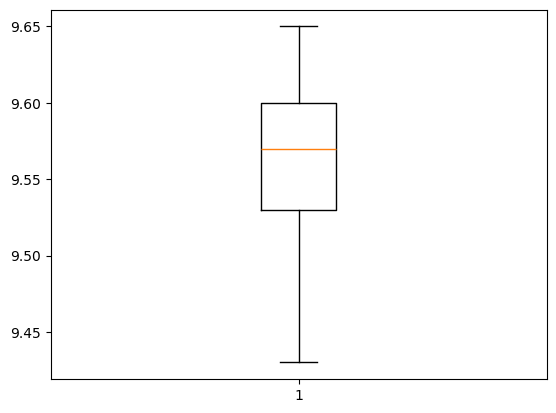

In [11]:
q1, _, q3 = np.percentile(cn7_Y["Injection_Time"], [25,50,75])
iqr= q3-q1
upper_bound = q3 + (1.5*iqr)
lower_bound = q1 - (1.5*iqr)
upper_bound
cn7_Y = cn7_Y[(cn7_Y["Injection_Time"]<=upper_bound) & (cn7_Y["Injection_Time"]>=lower_bound)]

plt.boxplot(cn7_Y["Injection_Time"])
plt.show()

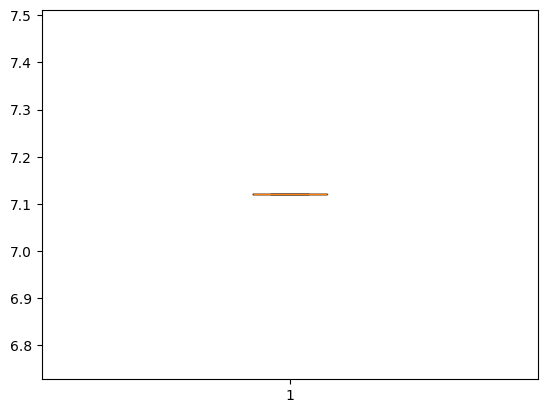

In [12]:
q1, _, q3 = np.percentile(cn7_Y["Clamp_Close_Time"], [25,50,75])
iqr= q3-q1
upper_bound = q3 + (1.5*iqr)
lower_bound = q1 - (1.5*iqr)
upper_bound
cn7_Y = cn7_Y[(cn7_Y["Clamp_Close_Time"]<=upper_bound) & (cn7_Y["Clamp_Close_Time"]>=lower_bound)]

plt.boxplot(cn7_Y["Clamp_Close_Time"])
plt.show()

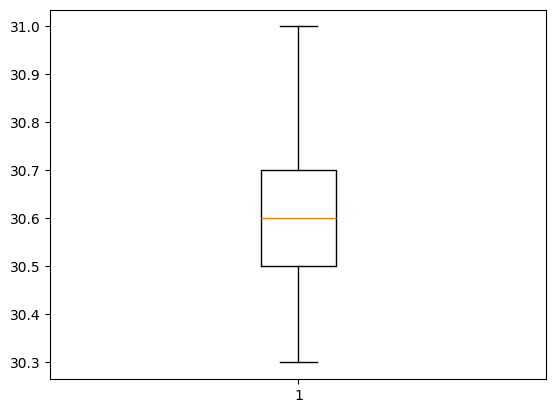

In [13]:
q1, _, q3 = np.percentile(cn7_Y["Max_Screw_RPM"], [25,50,75])
iqr= q3-q1
upper_bound = q3 + (1.5*iqr)
lower_bound = q1 - (1.5*iqr)
upper_bound
cn7_Y = cn7_Y[(cn7_Y["Max_Screw_RPM"]<=upper_bound) & (cn7_Y["Max_Screw_RPM"]>=lower_bound)]

plt.boxplot(cn7_Y["Max_Screw_RPM"])
plt.show()

In [14]:
cn7 = pd.concat([cn7_Y, cn7_N],ignore_index=True)
cn7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PassOrFail              4226 non-null   int64  
 1   Injection_Time          4226 non-null   float64
 2   Clamp_Close_Time        4226 non-null   float64
 3   Max_Screw_RPM           4226 non-null   float64
 4   Average_Screw_RPM       4226 non-null   float64
 5   Max_Injection_Pressure  4226 non-null   float64
 6   Average_Back_Pressure   4226 non-null   float64
 7   Barrel_Temperature_1    4226 non-null   float64
 8   Barrel_Temperature_4    4226 non-null   float64
 9   Hopper_Temperature      4226 non-null   float64
 10  Mold_Temperature_3      4226 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 363.3 KB


In [15]:
X = cn7.drop(columns=["PassOrFail"])
y = cn7["PassOrFail"]
X_test = rg3.drop(columns=["PassOrFail"])
y_test = rg3["PassOrFail"]

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2958, 10), (1268, 10), (2958,), (1268,))

In [17]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled = ss.transform(X_test)

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

model_list = [rf, et, gb, hgb, xgb]

grid_df = pd.DataFrame()
# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    df_temp = pd.DataFrame([[model_name, train_acc, val_acc, pre, rec, f1, train_acc-val_acc, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈령정확도", "검증정확도", 
                                      "정밀도", "재현율", "f1-score", "훈련-검증",  "파라미터"])
    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)
grid_df

,모델명,훈령정확도,검증정확도,정밀도,재현율,f1-score,훈련-검증,파라미터
0,RandomForestClassifier,1.000000,1.000000,1.000000,1.0,1.000000,0.000000,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
1,ExtraTreesClassifier,1.000000,1.000000,1.000000,1.0,1.000000,0.000000,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,1.000000,1.000000,1.000000,1.0,1.000000,0.000000,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
3,HistGradientBoostingClassifier,1.000000,1.000000,1.000000,1.0,1.000000,0.000000,"{'max_depth': 10, 'max_iter': 20, 'min_samples..."
4,XGBClassifier,0.999662,0.999211,0.999204,1.0,0.999602,0.000451,"{'max_depth': 10, 'min_child_weight': 1, 'n_es..."


In [19]:
#RandomForest
grid_df["파라미터"][0]

"{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}"

In [20]:
model = RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=20)

In [21]:
from sklearn.metrics import confusion_matrix
model.fit(X_train_scaled, y_train)
val_pred = model.predict(X_val_scaled)
confusion_matrix(val_pred, y_val)

array([[  13,    0],
       [   0, 1255]], dtype=int64)

<Axes: >

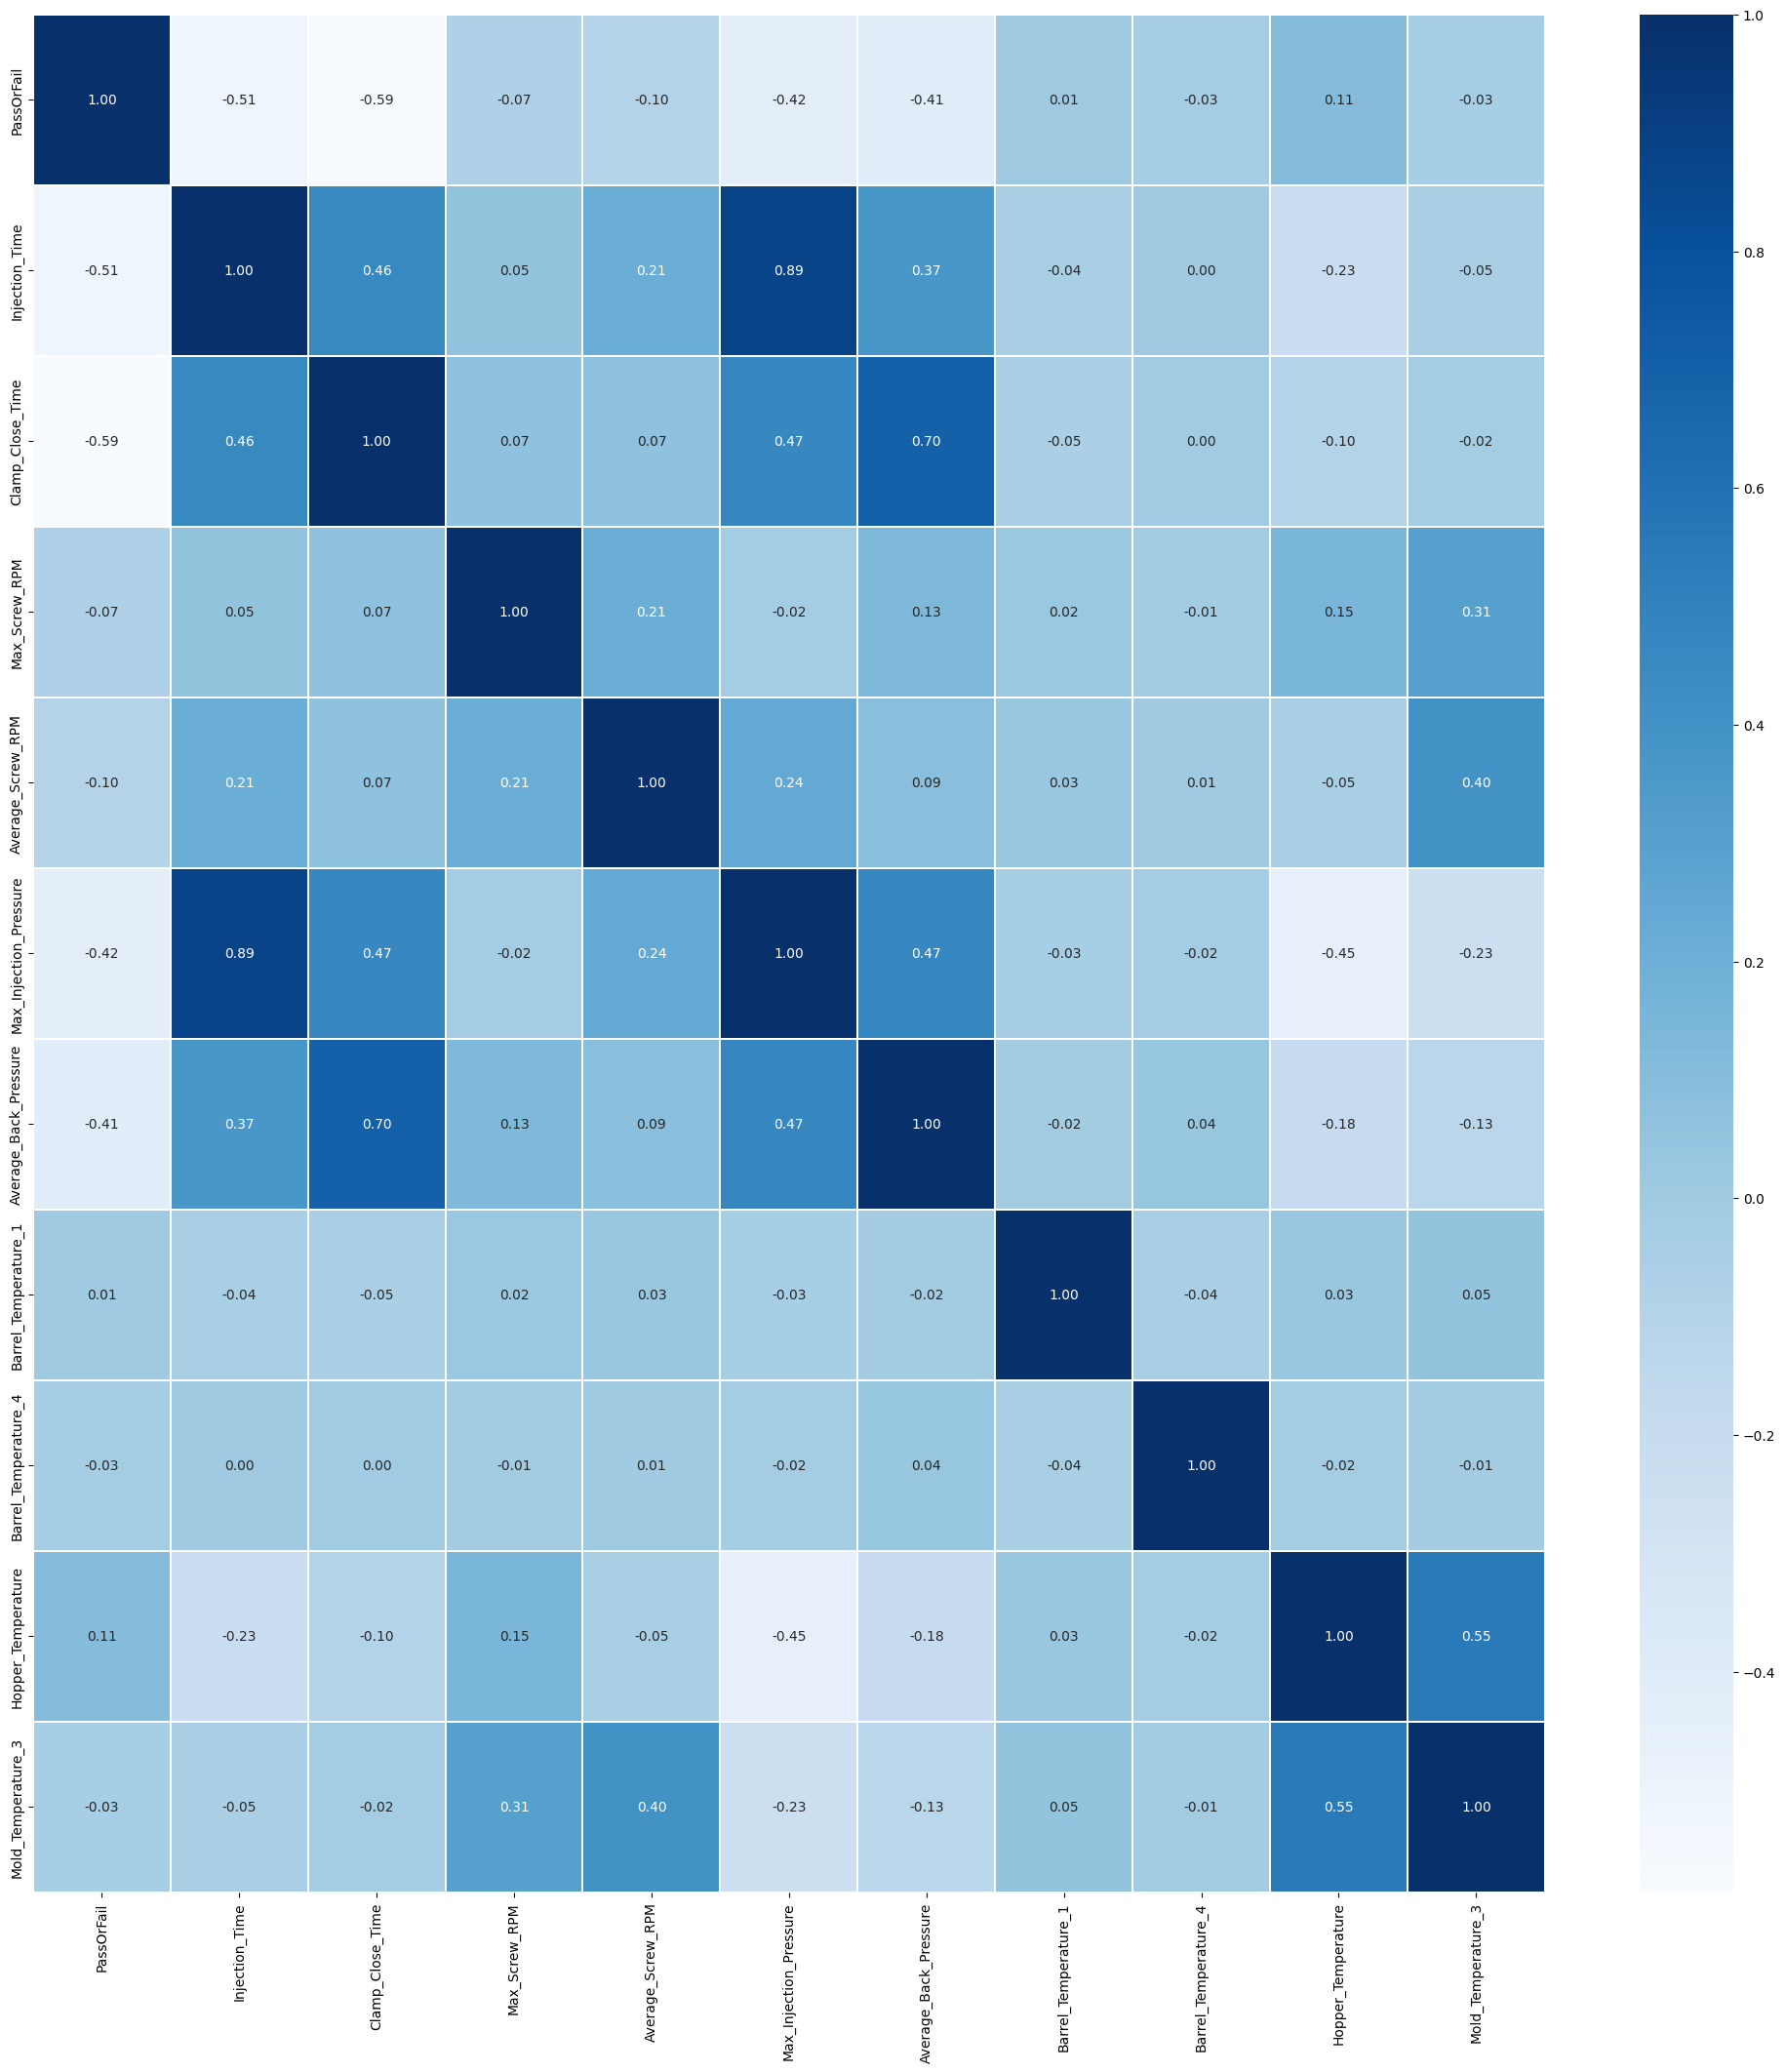

In [22]:
plt.subplots(figsize=(25,25))
sns.heatmap(data=cn7.corr(), linewidths=0.1, annot=True, fmt='.2f', cmap='Blues')

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

# Stratified 5-fold CV
skfold = StratifiedKFold(n_splits=5, shuffle=False)
cv_index = skfold.split(X, y)
cv_accuracy = []
ind = 1

for train_index, test_index in cv_index:
    # .iloc 사용하여 데이터 선택
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 모델 학습 및 평가
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1 = f1_score(y_test, pred)

    print(f'{ind}번째 Cross Validation 정확도: {f1:.2%}')
    cv_accuracy.append(accuracy)

    ind += 1

print(f'''-------------------------------------------
Cross Validation 정확도 평균: {np.mean(f1):.2%}''')


1번째 Cross Validation 정확도: 84.89%
2번째 Cross Validation 정확도: 100.00%
3번째 Cross Validation 정확도: 100.00%
4번째 Cross Validation 정확도: 100.00%
5번째 Cross Validation 정확도: 100.00%
-------------------------------------------
Cross Validation 정확도 평균: 100.00%
